# Universidad del Desarrollo
## Magister Data Science - Macroeconomía
### Grupo N°2: (Región de los Lagos)
* Jose Pedro
* Cristian
* Paul
* Max
* Hernan


# Imputación de los datos

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats.mstats import gmean

In [2]:
df = pd.read_csv('output/rlagos_canasta.csv')

In [3]:
df.head()

,Calidad,Mes/Año,Momento,Precio máximo,Precio mínimo,Precio promedio,Procedencia,Producto,Sector,Tipo,Tipo punto monitoreo,Unidad,Variedad
0,NaN,08/2014,2014-08,2249,1129,1558.2966,NaN,Maravilla,Osorno,Aceite,NaN,$/litro,NaN
1,NaN,08/2014,2014-08,1735,790,1410.9042,NaN,Vegetal,Osorno,Aceite,NaN,$/litro,NaN
2,NaN,08/2014,2014-08,1719,1220,1516.6203,NaN,Maravilla,Puerto Montt,Aceite,NaN,$/litro,NaN
3,NaN,08/2014,2014-08,1749,809,1357.3113,NaN,Vegetal,Puerto Montt,Aceite,NaN,$/litro,NaN
4,NaN,09/2014,2014-09,1768,1589,1680.2222,NaN,Maravilla,Frutillar,Aceite,NaN,$/litro,NaN


In [4]:
df.shape

(32362, 13)

### Paso 1: buscar todos los promedios geometricos

Creamos un dataset nuevo con todas las combinaciones Tipo / Sector

In [5]:
Combos = df.groupby(['Tipo','Producto','Sector']).count().reset_index()[['Tipo','Producto','Sector']]

In [6]:
Combos.head()

,Tipo,Producto,Sector
0,Aceite,Maravilla,Frutillar
1,Aceite,Maravilla,Llanquihue
2,Aceite,Maravilla,Osorno
3,Aceite,Maravilla,Puerto Montt
4,Aceite,Maravilla,Puerto Varas


Una prueba para ver como calculamos el promedio geometrico de una combinación a mano, antes de crear una función:

In [7]:
gmean(df[(df.Tipo == 'Aceite') & (df.Producto == 'Maravilla') & (df.Sector == 'Osorno')]['Precio promedio'])

1619.1497080362053

Creamos una función que calcula el promedio geometrico en base al dataframe completo, pero filtrado por el dataframe Tipo / Producto / Sector

In [8]:
def calc_gmean(row):
    Tipo = row['Tipo']
    Producto = row['Producto']
    Sector = row['Sector']
    a = gmean(df[(df.Tipo == Tipo) & (df.Producto == Producto) & (df.Sector == Sector)]['Precio promedio'])
    return a

Aplicamos la función a cada fila del dataframe con las combinaciones Tipo / Producto / Sector

In [9]:
Combos['PromGeo'] = Combos.apply(calc_gmean, axis=1)

In [10]:
Combos.sample(10)

,Tipo,Producto,Sector,PromGeo
343,Hortaliza,Brócoli,Puerto Varas,834.132650
96,Carnes,Malaya,Osorno,4851.281622
267,Frutas,Mango,Llanquihue,1774.353843
57,Carnes,Chuleta (centro),Osorno,4114.882353
487,Lacteos,Queso Mantecoso,Osorno,7056.176683
456,Lacteos,Leche en Polvo Descremada,Llanquihue,4091.658812
191,Carnes,Sobrecostilla,Puerto Montt,4632.471205
66,Carnes,Estomaguillo (Tapabarriga),Llanquihue,6041.823571
417,Hortaliza,Tomate,Osorno,942.077389
246,Frutas,Frambuesa,Osorno,2114.741437


### Paso 2: Rellenar lo faltante

Estrategia:

1. Crear un dataframe con todas las fechas (momentos) del periodo.
1. A partir de cada columna en el dataframe *Combos*, crear un dataframe de una combinación Tipo/Producto/Sector
1. Hacer un merge entre el dataset de los momentos y el dataset Tipo/Producto/Sector para ver qué son los *momentos* que no tienen valores
1. Llenar los NaN con el promedio geometrico (y otros datos faltantes dado que estas filas no existían antes)
1. Crear un nuevo dataframe donde vamos agregando los dataframes de Tipo/Producto/Sector a medida que se completen.

In [11]:
df_momentos = pd.DataFrame(df['Momento'])
df_momentos.drop_duplicates(subset='Momento', keep='first', inplace=True)
df_momentos.reset_index()
df_momentos.shape

(47, 1)

In [12]:
df_final = pd.DataFrame([])

def fill_nans(row):
    global df_final
    Tipo = row['Tipo']
    Producto = row['Producto']
    Sector = row['Sector']
    PromGeo = row['PromGeo']
    # Creamos un dataset con la combinación
    data = df[(df.Tipo == Tipo) & (df.Producto == Producto) & (df.Sector == Sector)][['Momento','Precio promedio','Tipo','Producto','Sector']]
    # Hacemos merge con el dataset que contiene todos los momentos
    data = pd.merge(df_momentos, data, on='Momento', how='left')
    # Llenamos los NaN
    data['Precio promedio'].fillna(PromGeo, inplace=True)
    data['Tipo'].fillna(Tipo, inplace=True)
    data['Producto'].fillna(Producto, inplace=True)
    data['Sector'].fillna(Sector, inplace=True)
    # Agregamos la data a al dataframe completo
    df_final = df_final.append(data)
    pass

In [13]:
Combos.apply(fill_nans, axis=1)
df_final.head()

,Momento,Precio promedio,Tipo,Producto,Sector
0,2014-08,1807.484158,Aceite,Maravilla,Frutillar
1,2014-09,1680.222200,Aceite,Maravilla,Frutillar
2,2014-10,1651.904700,Aceite,Maravilla,Frutillar
3,2014-11,1807.484158,Aceite,Maravilla,Frutillar
4,2014-12,1807.484158,Aceite,Maravilla,Frutillar


In [14]:
df_final.shape

(38265, 5)

In [15]:
df_final.reset_index(inplace=True)

Test con los que sabemos que estaban missing:

In [16]:
df_final[(df_final.Tipo == 'Hortaliza') & (df_final.Producto == 'Repollo') & (df_final.Sector == 'Frutillar') & (df_final.Momento == '2014-08')]

,index,Momento,Precio promedio,Tipo,Producto,Sector
29506,0,2014-08,1205.594772,Hortaliza,Repollo,Frutillar


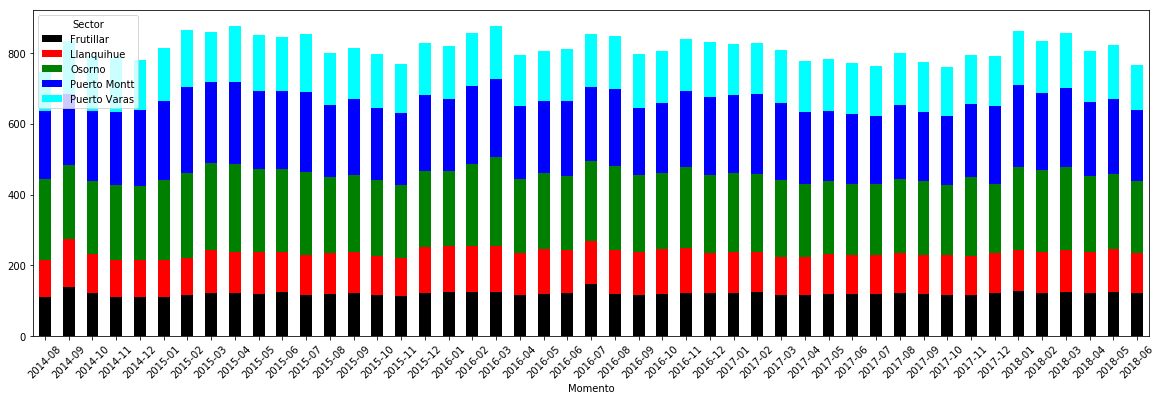

In [17]:
dx = df_final.groupby(["Momento", "Sector"])['Producto'].size().unstack()

mycolor=['black', 'red', 'green', 'blue', 'cyan']

dx.plot(kind='bar', stacked=True, figsize=(20, 6), color=mycolor, rot=45)

In [18]:
df = df_final[["Momento", "Sector", "Tipo", "Producto", "Precio promedio"]]

In [19]:
df.rename(columns={'Producto': 'Variedad', 'Precio promedio': 'Promedio', 'Tipo': 'Producto'}, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [20]:
df.to_csv('output/canasta_ipc.csv', index=False)